# openEO remote processing

## Setting-up a Python session

We begin by loading openEO and some additional packages. In this exercise we make use of a local variant of openEO as the data is not yet available on an accessible data store.


In [1]:
import numpy as np
import xarray as xr
from datetime import datetime

from openeo_flood_mapper_local.view_flood_map import view_flood_map

import openeo
from openeo.processes import ProcessBuilder, array_element, add, multiply, sin, cos, mask, exp, median

## Connect to the EODC openEO back-end

Establish a connection to the EODC backend with `openeo.connect()`. This results in a connection object which is a critical aspect of collection discovery on the back-end by openEO. 


In [2]:
backend = "https://openeo.eodc.eu" 
connection = openeo.connect(backend)
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.eodc.eu/openeo/1.1.0/' with OidcBearerAuth>

## Load collections

We can then load the collections. This is done by using the method `load_collection()` and by using the collection ids as defined above.


In [3]:
spatial_extent = {"west": 22, "south": 39.483774, "east": 22.225465, "north": 39.6}
sensing_date = ["2018-02-28T04:00:00Z", "2018-02-28T05:00:00Z"]

### Microwave Backscatter


In [4]:
#| code-fold: true
connection.collection_metadata("SENTINEL1_SIG0_20M")

In [5]:
sig0_dc = connection.load_collection(
    "SENTINEL1_SIG0_20M",
    spatial_extent = spatial_extent,
    temporal_extent = sensing_date,
    bands=["VV"]
). \
    mean_time()

### Harmonic parameters


In [6]:
#| code-fold: true
connection.collection_metadata("SENTINEL1_HPAR")

In [7]:
hparam_dc = connection.load_collection(
    "SENTINEL1_HPAR",
    spatial_extent = spatial_extent,
    temporal_extent = "2019"
). \
    mean_time()

### Local Incidence Angle


In [8]:
#| code-fold: true
connection.collection_metadata("SENTINEL1_MPLIA")

In [9]:
plia_dc = connection.load_collection(
    "SENTINEL1_MPLIA",
    spatial_extent = spatial_extent,
    temporal_extent = ["2020-01-01", "2020-12-31"],
    bands=["MPLIA"]
). \
    mean_time()

## openEO Analysis

openEO supplies a set of conventional and EO-specific functions (or "processes" in openEO terminology) to work with EO data. In this example, we begin by defining functions that represent the flood mapping algorithm as defined in @bauer-marschallinger_satellite-based_2022, and by using standard openEO functions. The flood mapping algorithm extracts the following information: 1) the expected backscattering from water bodies, and 2) the expected backscatter intensity over land pixels given historical data. Hence, this function makes use of observations along both the spatial and temporal dimensions of the datacube.

We first define the function that extracts average backscatter intensity over water bodies and we name it `water_backscatter()`. This functions applies so-called openEO "band math", which are basically mathematical computations on the bands of the datacube. In this case, the band of the incidence angle (degrees) of the retrieved backscatter signal is multiplied by a factor consisting of the slope plus an intercept from a linear model. This linear model describes the relationship between incidence angle and backscattering over water globally. Applying this linear model results in expected water back scattering. In a follow-up, we use a so-called reducer function, taking the mean of the band over the time dimension, after which, we rename this dimension "wbsc" of type band.


In [10]:
def water_backscatter(plia_dc):
    return (plia_dc.band('MPLIA') * -0.394181 + -4.142015). \
        add_dimension('bands', 'wbsc', 'bands')

We can apply this function to the incidence angle datacube, as follows:


In [11]:
water_bsc_dc = water_backscatter(plia_dc)
water_bsc_dc

Here we can see the basic premise of openEO. The previous call did not actually perform the data processing it only generates a JSON representation of the processing graph. Only by submitting a job to the EODC backend, we can actually perform the processing, like so:


In [12]:
#| eval: false
water_bsc_res = water_bsc_dc.save_result(format = "NetCDF")
water_bsc_job = water_bsc_res.create_job(title = "water_bsc_greece_flood_2018_as_NetCDF_py")
water_bsc_job.start_job()

In [13]:
#| eval: false
water_bsc_job.download_result("data/watter_backscatter/example.nc")

We can then download the results from EODC.


In [14]:
#| eval: false
water_bsc_dc = xr.open_dataset("data/watter_backscatter/example.nc")
water_bsc_dc

We define a second function to obtain expected backscattering over land pixels. In this case we will have to use historical Sentinel-1 data for each pixel to negate the effect of seasons on the sigma nought signal. Hence a so-called harmonic model is fitted. The following function `harmonic_expected_backscatter()` uses this harmonic model for estimations optimised to filter out seasonal signals. 


In [15]:
def harmonic_expected_backscatter(data, dtime_str):
    w = np.pi * 2 / 365
    dt = datetime.strptime(dtime_str, "%Y-%m-%d")
    t = dt.timetuple().tm_yday
    wt = w * t

    M0 = data.band('M0')
    S1 = data.band('S1')
    S2 = data.band('S2')
    S3 = data.band('S3')
    C1 = data.band('C1')
    C2 = data.band('C2')
    C3 = data.band('C3')
    hm_c1 = (M0 + S1 * np.sin(wt)) + (C1 * np.cos(wt))
    hm_c2 = ((hm_c1 + S2 * np.sin(2 * wt)) + C2 * np.cos(2 * wt))
    hm_c3 = ((hm_c2 + S3 * np.sin(3 * wt)) + C3 * np.cos(3 * wt))
    return hm_c3.add_dimension('bands', 'hbsc', 'bands')

We can now again apply this function to a datacube. For this operation we use the `hparam_dc` datacube defining the harmonic parameters of said model. These parameters together with the date of the flooding event generate the expected backscattering per land pixel.


In [16]:
land_bsc_dc = harmonic_expected_backscatter(hparam_dc, '2018-02-01')

So far we have covered a couple of the core features of the openEO Python Client syntax. However, in all these cases, the shape of the datacube was not altered. In the following section we cover what to do when want to change shape through accumulation or reduction of input values.

## Processes with Child “callbacks”

Now we will define the last function, which calculates the probability of flooding with a Bayesian classification model. The output of this function tells if a pixel is flooded based on the previous defined expected land and water backscattering. The implementation of this function is, however, different from the previous functions, as it is applied to subsets of datacubes through the openEO function `reduce_bands()` and it thereby changes the shape of the input values. This family of functions, which also includes, e.g., `apply()`, `reduce_dimension()`, and `aggregate_spatial()`, are known as the "parent" functions. These parent functions invoke a subprocess on the datacube, so-called child "callbacks".

The following function will be used as a child callback to calculate flooding probabilities. Note that the function requires the openEO helper object `ProcessBuilder`. 


In [17]:
def bayesian_flood_decision(x: ProcessBuilder) -> ProcessBuilder:
    nf_std = 2.754041
    sig0 = x.array_element(index=0)
    std = x.array_element(index=1)
    wbsc = x.array_element(index=2)
    hbsc = x.array_element(index=3)

    f_prob = (1.0 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * \
        (((sig0 - wbsc) / nf_std) ** 2))
    nf_prob = (1.0 / (nf_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * \
        (((sig0 - hbsc) / nf_std) ** 2))

    evidence = (nf_prob * 0.5) + (f_prob * 0.5)
    f_post_prob = (f_prob * 0.5) / evidence 
    nf_post_prob = (nf_prob * 0.5) / evidence 

    # flood if flood class has higher probability
    return f_post_prob.gt(nf_post_prob)

We will use a child callback to reduce a datacube consisting of the expected backscatter over water, the expected backscattering over land and it's standard deviation, and the sigma nought values to one new band comprising the flood classifications per pixel.

For this we will first have to load the standard deviations of the expected land backscattering for each pixel and the sigma nought values for the particular timeperiod of the expected flooding (February 2018).


In [18]:
std_dc = hparam_dc.band('STD').add_dimension('bands', 'std', 'bands')
sig0_dc = sig0_dc.reduce_bands('mean').add_dimension('bands', 'sig0', 'bands')

Now we can merge all these datacubes, like so:


In [19]:
decision_in_dc = sig0_dc. \
    merge_cubes(std_dc). \
    merge_cubes(water_bsc_dc). \
    merge_cubes(land_bsc_dc) . \
    merge_cubes(plia_dc)

# Classification

The merged preprocessed datacube can then be used as input for the Bayesian flood mapping function that reduces all these bands to just one in the resulting datacube.


In [20]:
flood_dc = decision_in_dc.reduce_bands(bayesian_flood_decision). \
    add_dimension('bands', 'dec', 'bands')
flood_dc = flood_dc.merge_cubes(decision_in_dc)

In [21]:
#| eval: false
flood_res = flood_dc.save_result(format = "NetCDF")
flood_job = flood_res.create_job(title = "flood_greece_flood_2018_as_NetCDF_py")
flood_job.start_job()

In [22]:
#| eval: false
flood_job.download("data/thessaly_floodmap.nc")

## openEO Flood Mapping

We can check the results of the openEO by executing the processing steps with `execute()` and by plotting the flood mapping classification.


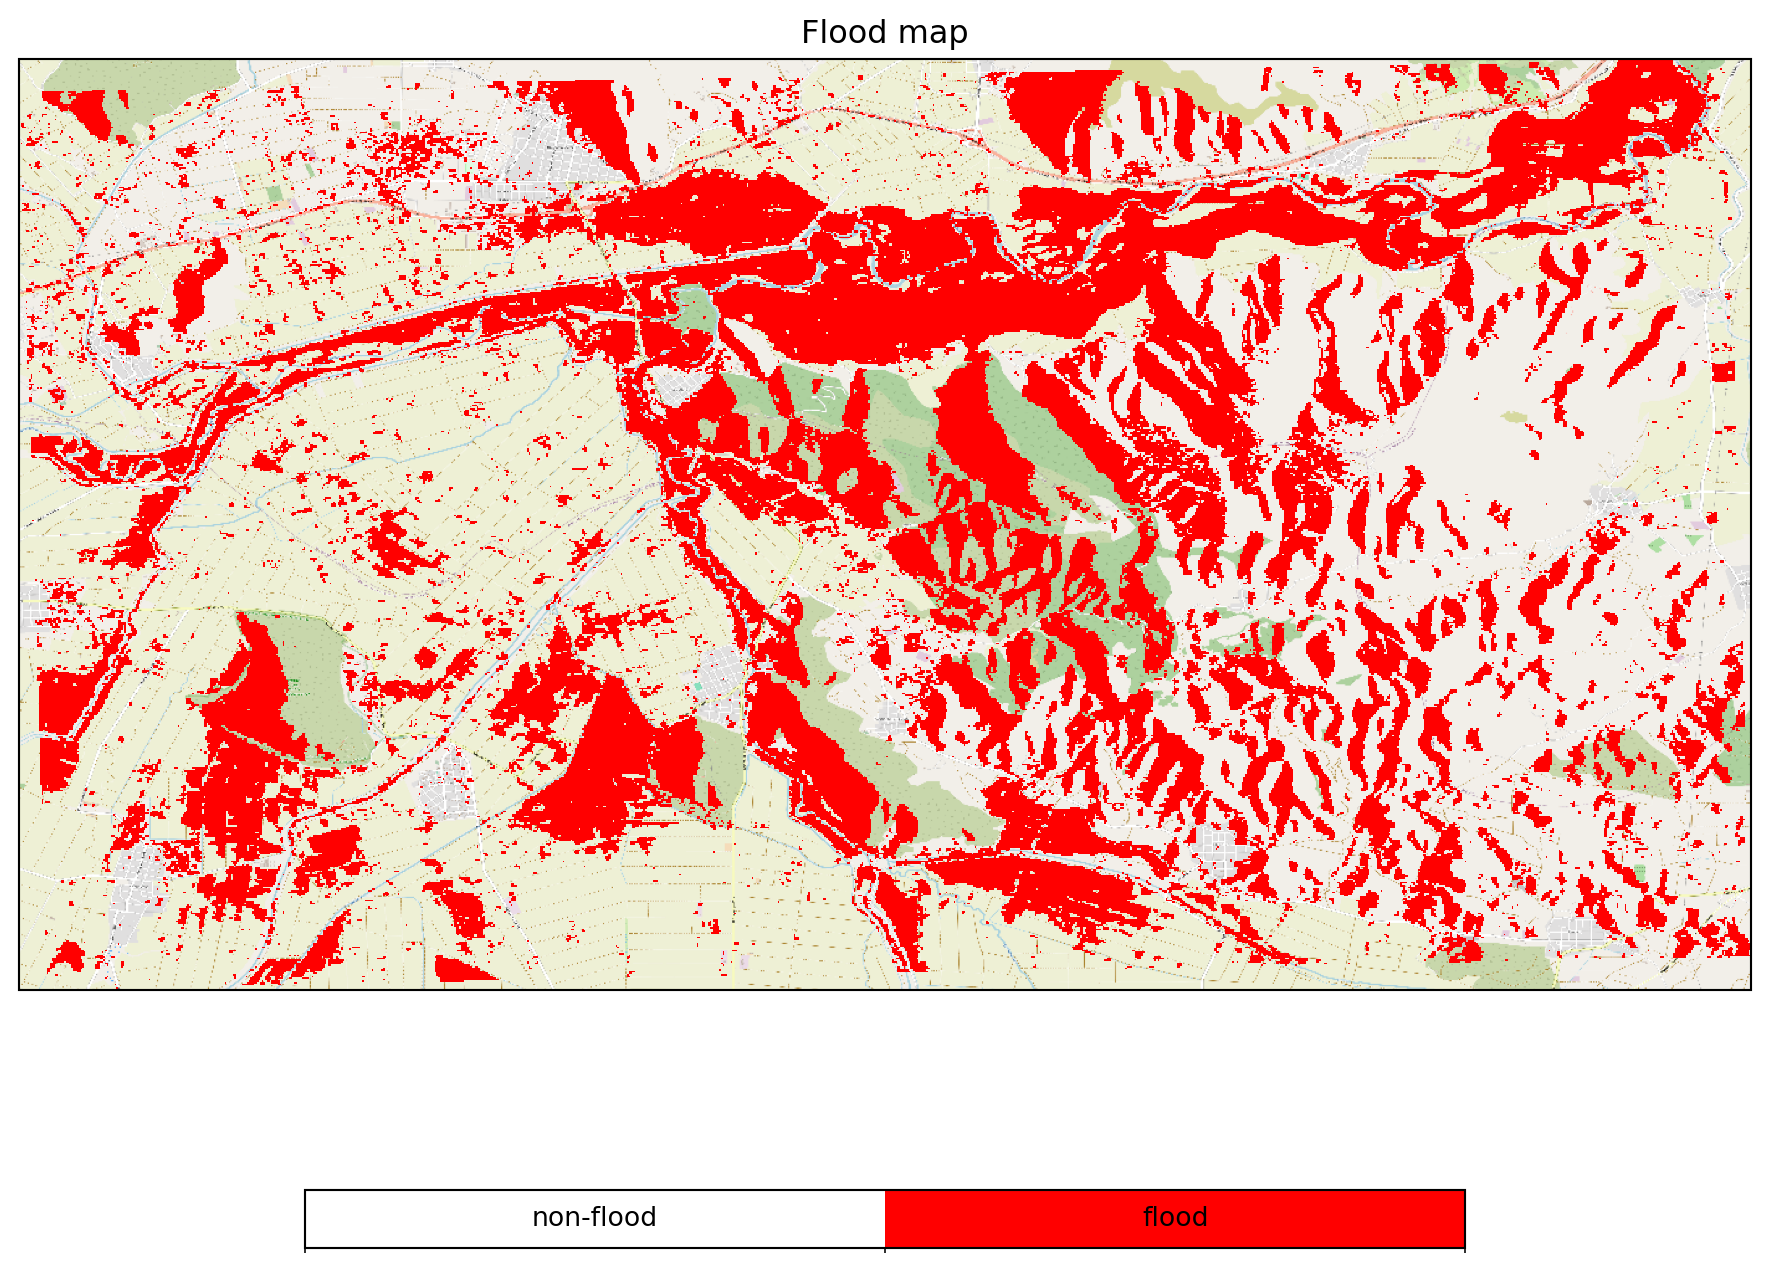

In [23]:
#| fig-cap: openEO floodmap - no pre-processing
view_flood_map(xr.open_dataset("data/thessaly_floodmap.nc").dec)

By comparing this figure with the original study [@bauer-marschallinger_satellite-based_2022], we see that the openEO workflow can perform the same operations. There are, however, some differences with the original flood mapping study. These differences relate to the absence of the low sensitivity masking and post-processing steps of the flood probabilities in the openEO workflow. A priori low sensitivity masking removes observations in which situations arise that cause insensitivity to flood conditions for physical, geometric, or sensor-side reasons. Whereas, post-processing removes e.g. the small patches of supposed flooded pixels scattered throughout the image also known as "speckles". These speckles produce a more noisy picture in the openEO example.

## Masking of Low Sensitivity Pixels

We continue by improving our flood map by filtering out observations that we expect to have low sensitivity to flooding based on a predefined set of criteria.

### Masking of Exceeding Incidence Angles

Firstly we mask areas where the incidence angle exceeds the maximum tolerable range of $27\degree$ to $48\degree$. These larger than usual incidence angles are a result of the area's topography as beams reflect from steep slopes. 


In [24]:
mask_ia = (flood_dc.band("MPLIA") >= 27) * (flood_dc.band("MPLIA") <= 48)
flood_dc = flood_dc * mask_ia

In [25]:
#| eval: false
#| echo: false
flood_res = flood_dc.save_result(format = "NetCDF")
flood_job = flood_res.create_job(title = "flood_greece_flood_2018_as_NetCDF_py")
flood_job.start_job()

In [26]:
#| eval: false
#| echo: false
flood_job.download_result("data/thessaly_floodmap_plia.nc")

This results in the following map:


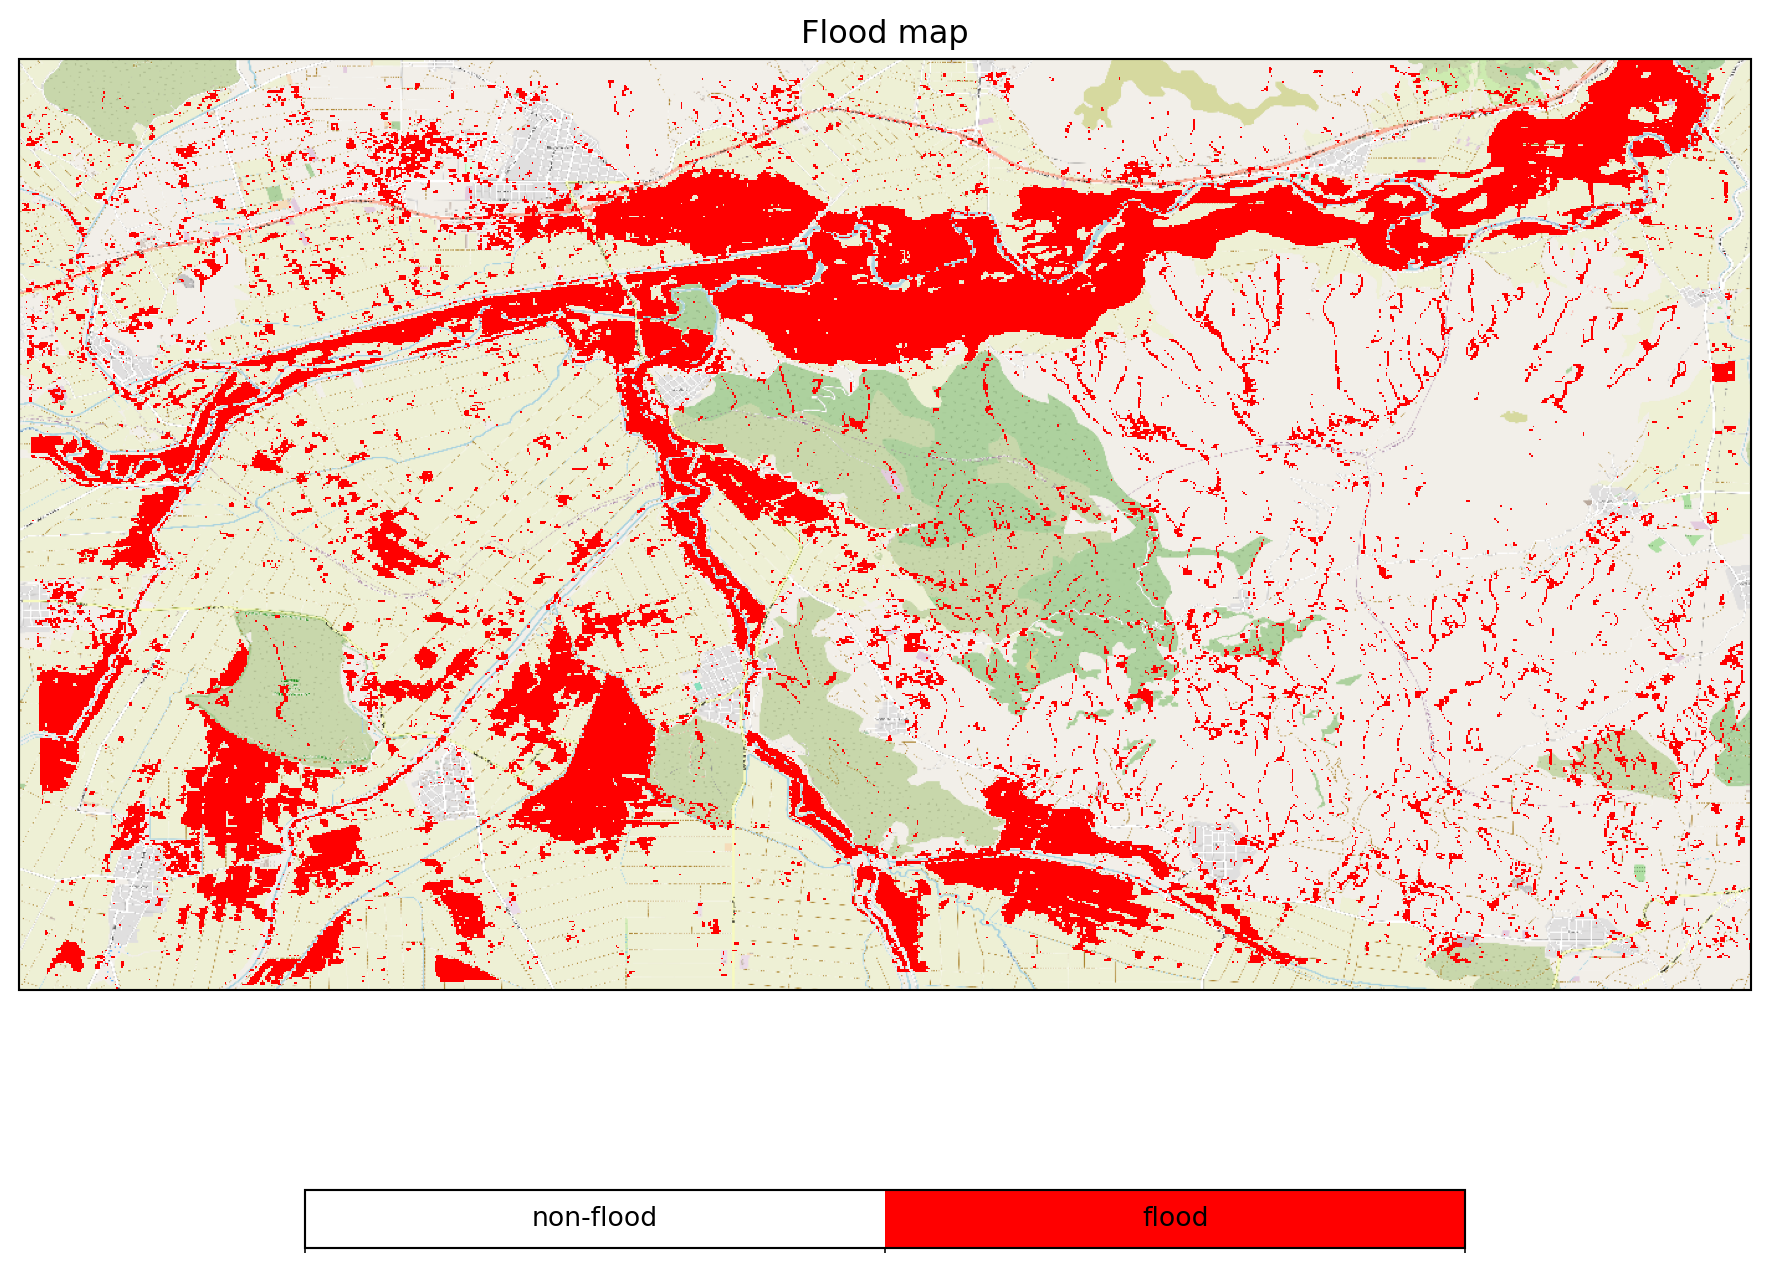

In [27]:
#| fig-cap: openEO floodmap - masking exceeding incidence angles
#| echo: false
view_flood_map(xr.open_dataset("data/thessaly_floodmap_plia.nc").dec)

### Identification of Conflicting Distributions

We remove values that have already low backscatter values during normal conditions and which do not represent water. Examples of such surfaces are highways, airstrips. salt panes, or arid sand and/or bedrock. Identification of such conflicting distribution is done by comparing the expected local land distribution (from the harmonic model) with those from the water distribution, if these cannot be distinguished from each other, the pixel is excluded.


In [28]:
water_bsc_threshold = flood_dc.band("wbsc") + 0.5 * 2.754041
mask_conflict = flood_dc.band("hbsc") > water_bsc_threshold
flood_dc = flood_dc * mask_conflict

In [29]:
#| eval: false
#| echo: false 
flood_res = flood_dc.save_result(format = "NetCDF")
flood_job = flood_res.create_job(title = "flood_greece_flood_2018_as_NetCDF_py")
flood_job.start_job()

In [30]:
#| eval: false
#| echo: false 
flood_job.download_result("data/thessaly_floodmap_plia_distr.nc")

Exclusion of these conflicting distributions look as follows:


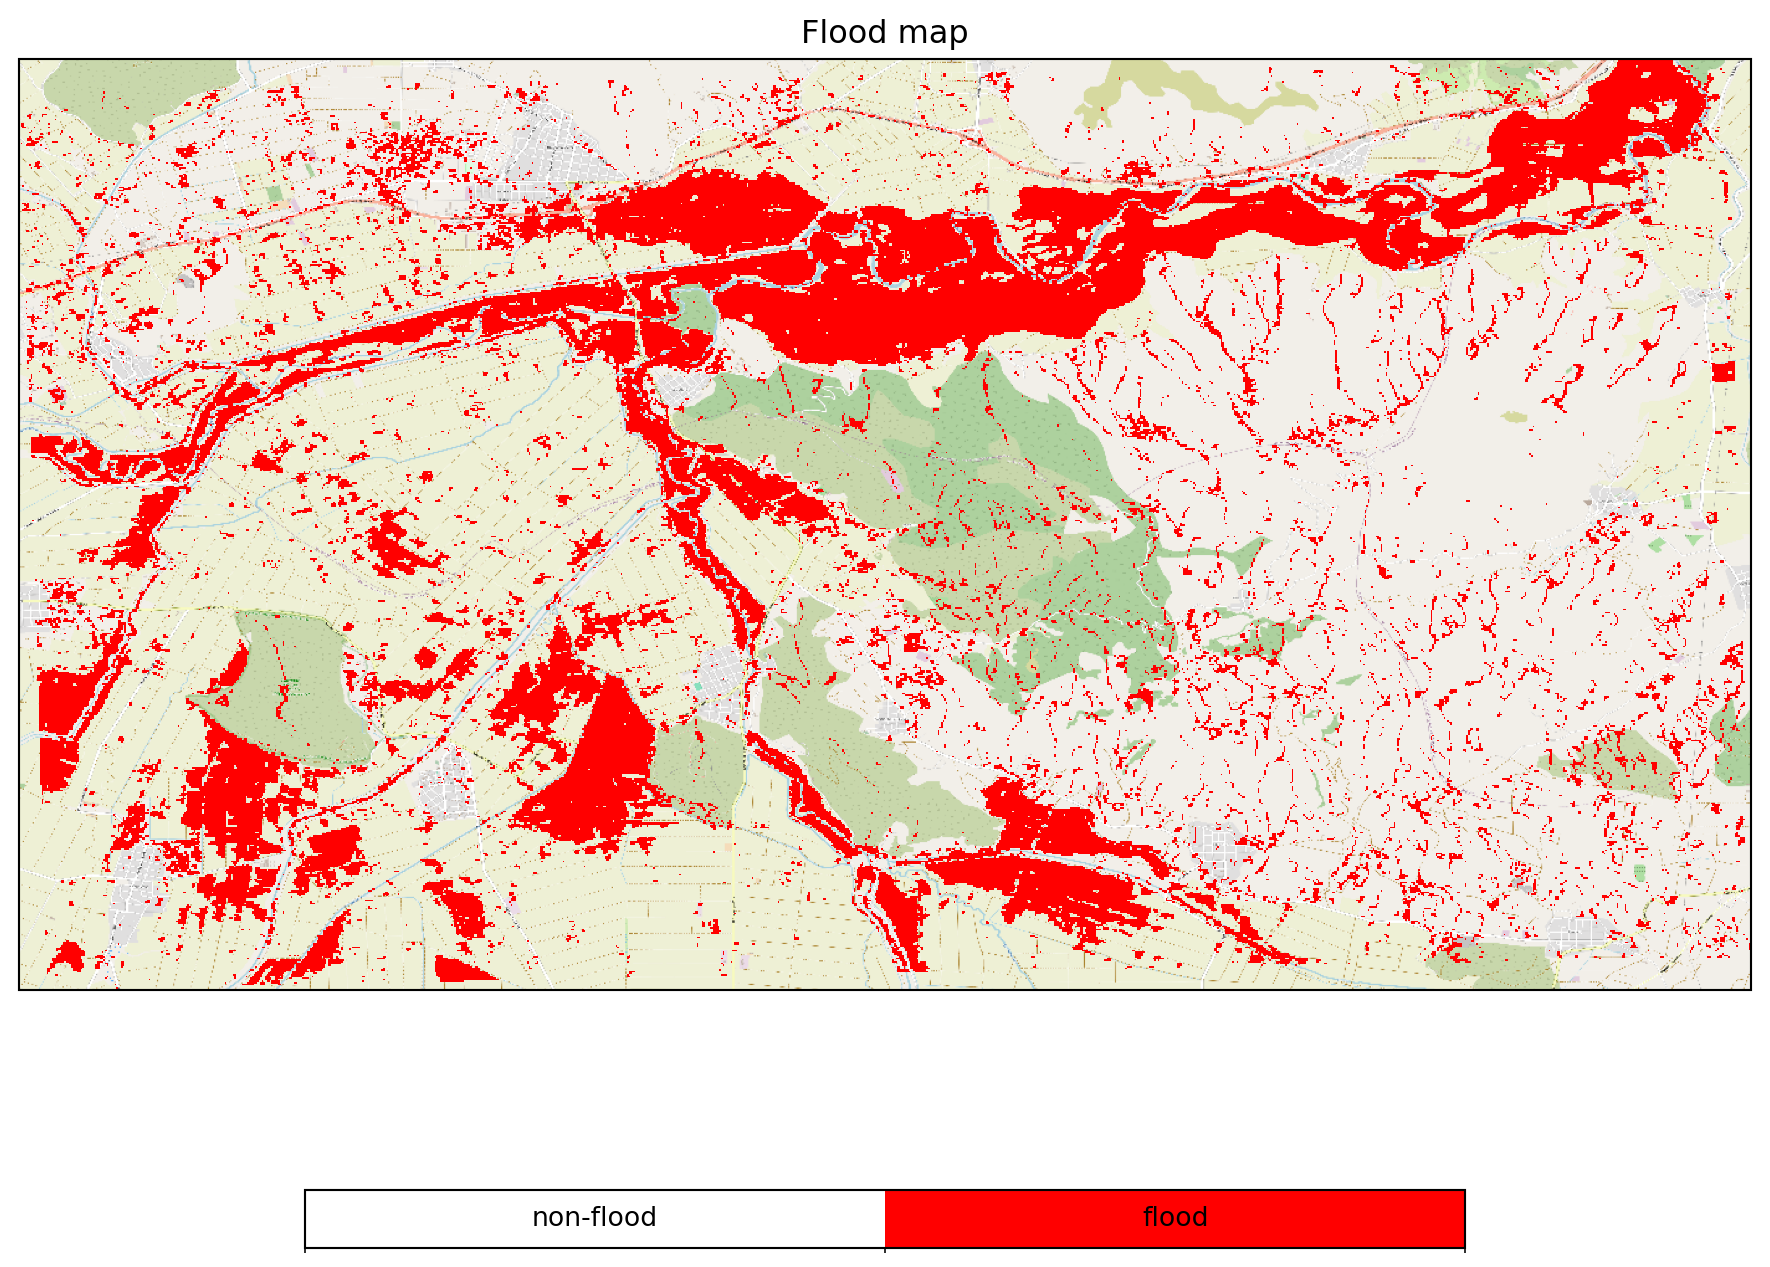

In [31]:
#| fig-cap: openEO floodmap - masking conflicting distributions + exceeding incidence angles
#| echo: false
view_flood_map(xr.open_dataset("data/thessaly_floodmap_plia_distr.nc").dec)

### Removal of Measurement Outliers

Extreme backscatter values are yet another source of insensitivity to floods. These outliers are not properly represented by the Bayesian model probabilities.


In [32]:
land_bsc_lower = flood_dc.band("hbsc") - 3 * flood_dc.band("std")
land_bsc_upper = flood_dc.band("hbsc") + 3 * flood_dc.band("std")
water_bsc_upper = flood_dc.band("wbsc") + 3 * 2.754041

mask_land_outliers = (flood_dc.band("sig0") > land_bsc_lower) * (flood_dc.band("sig0") < land_bsc_upper)
mask_water_outliers = flood_dc.band("sig0") < water_bsc_upper
flood_dc = flood_dc * (mask_land_outliers | mask_water_outliers)

In [33]:
#| eval: false
#| echo: false 
flood_res = flood_dc.save_result(format = "NetCDF")
flood_job = flood_res.create_job(title = "flood_greece_flood_2018_as_NetCDF_py")
flood_job.start_job()

In [34]:
#| eval: false
#| echo: false 
flood_job.download_result("data/thessaly_floodmap_plia_distr_out.nc")

Adding this to the prvious masking results in the following map:


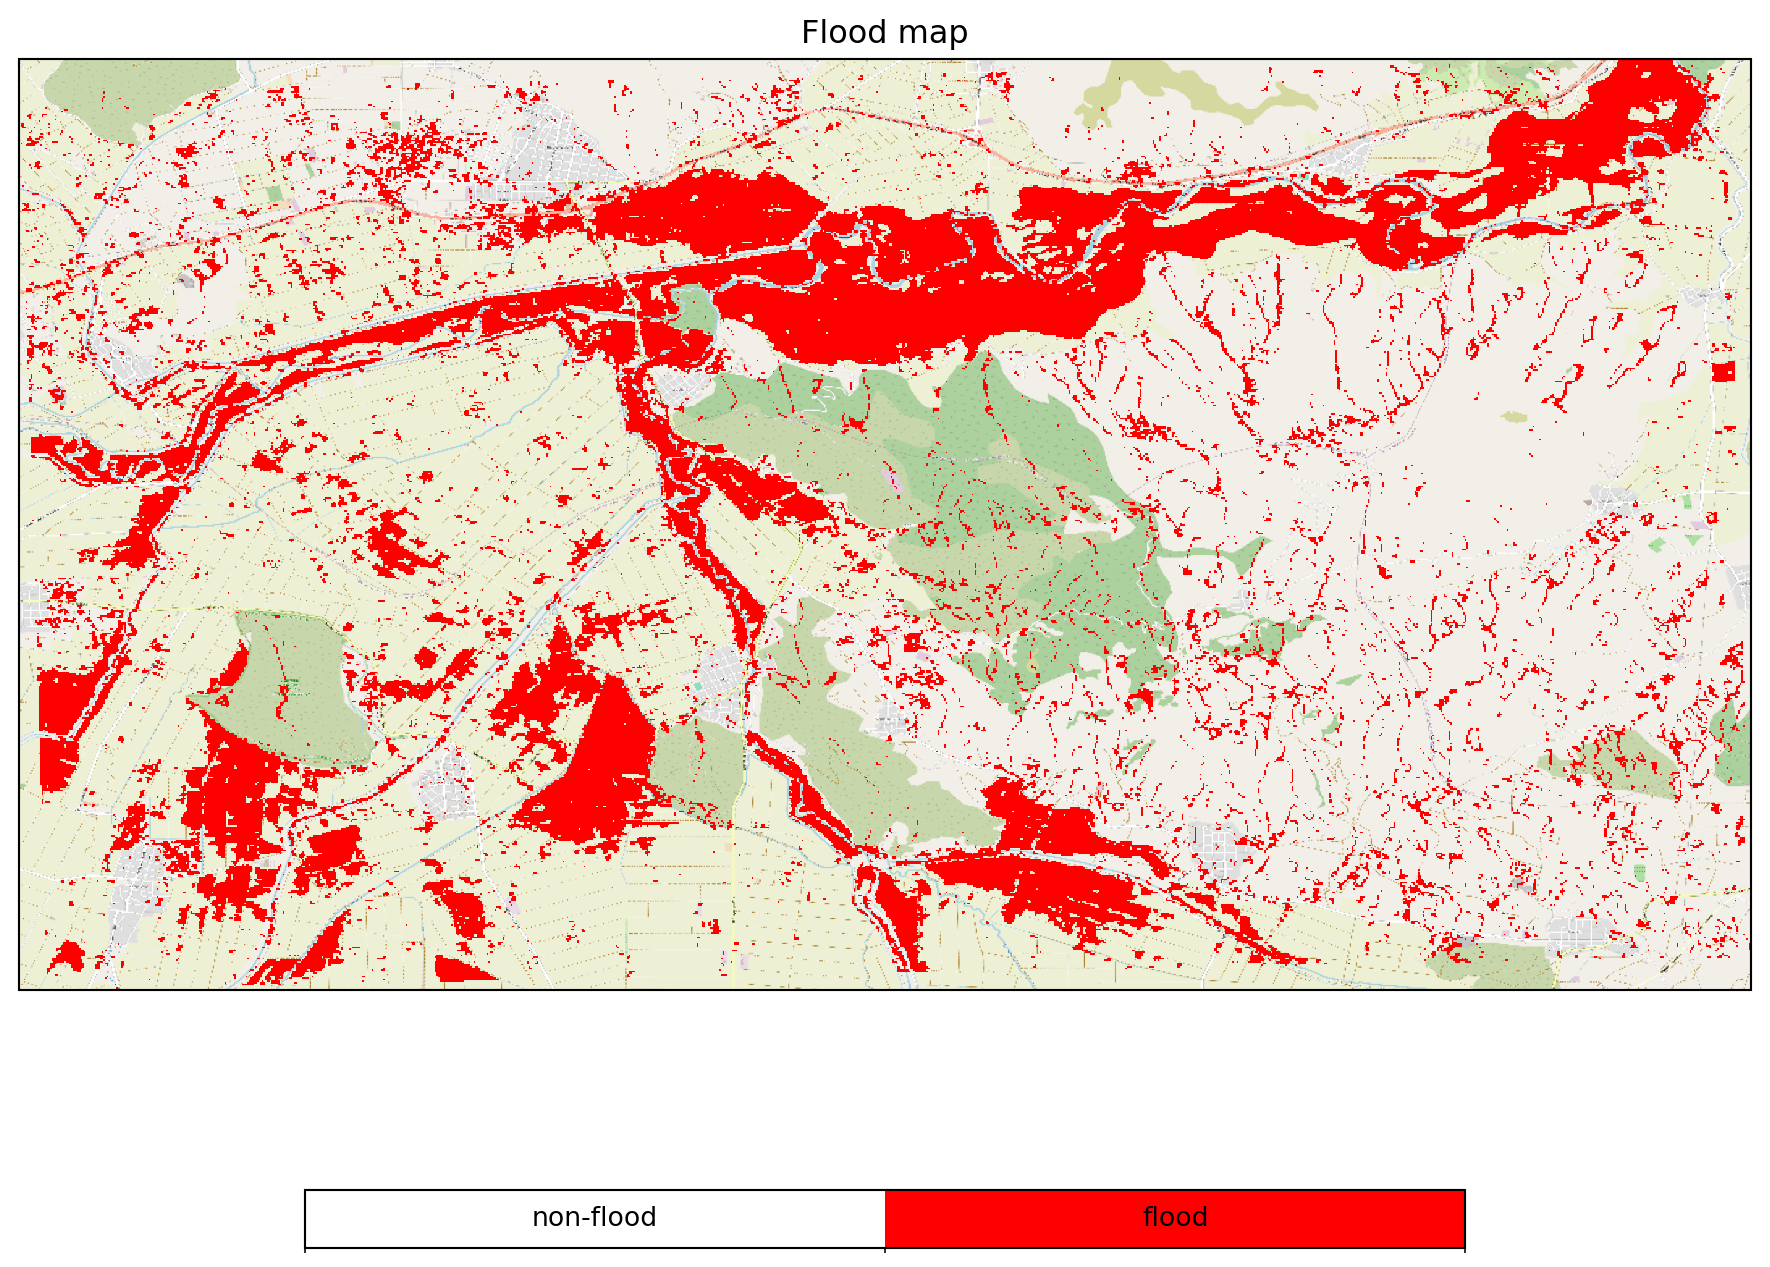

In [35]:
#| fig-cap: openEO floodmap - masking extreme outliers + conflicting distributions + exceeding incidence angles
#| echo: false
view_flood_map(xr.open_dataset("data/thessaly_floodmap_plia_distr_out.nc").dec)

### Denial of High Uncertainty on Decision

In some cases the posterior distribution is ambiguous as it falls close to a 0.5 probability of flooding (i.e., a coin flip). This happens when the probability distributions for water and land backscattering overlap and/or the measured backscatter values falls exactly in the middle of the two distributions. Hence a cut-off of 0.2 is used to limit the potential of falls positive classifications.


In [36]:
mask_uncertainty = flood_dc.band("dec") > 0.8
flood_dc = flood_dc * mask_uncertainty

In [37]:
#| eval: false
#| echo: false 
flood_res = flood_dc.save_result(format = "NetCDF")
flood_job = flood_res.create_job(title = "flood_greece_flood_2018_as_NetCDF_py")
flood_job.start_job()

In [38]:
#| eval: false
#| echo: false 
flood_job.download_result("data/thessaly_floodmap_plia_distr_out_den.nc")

This results in the following floodmap.


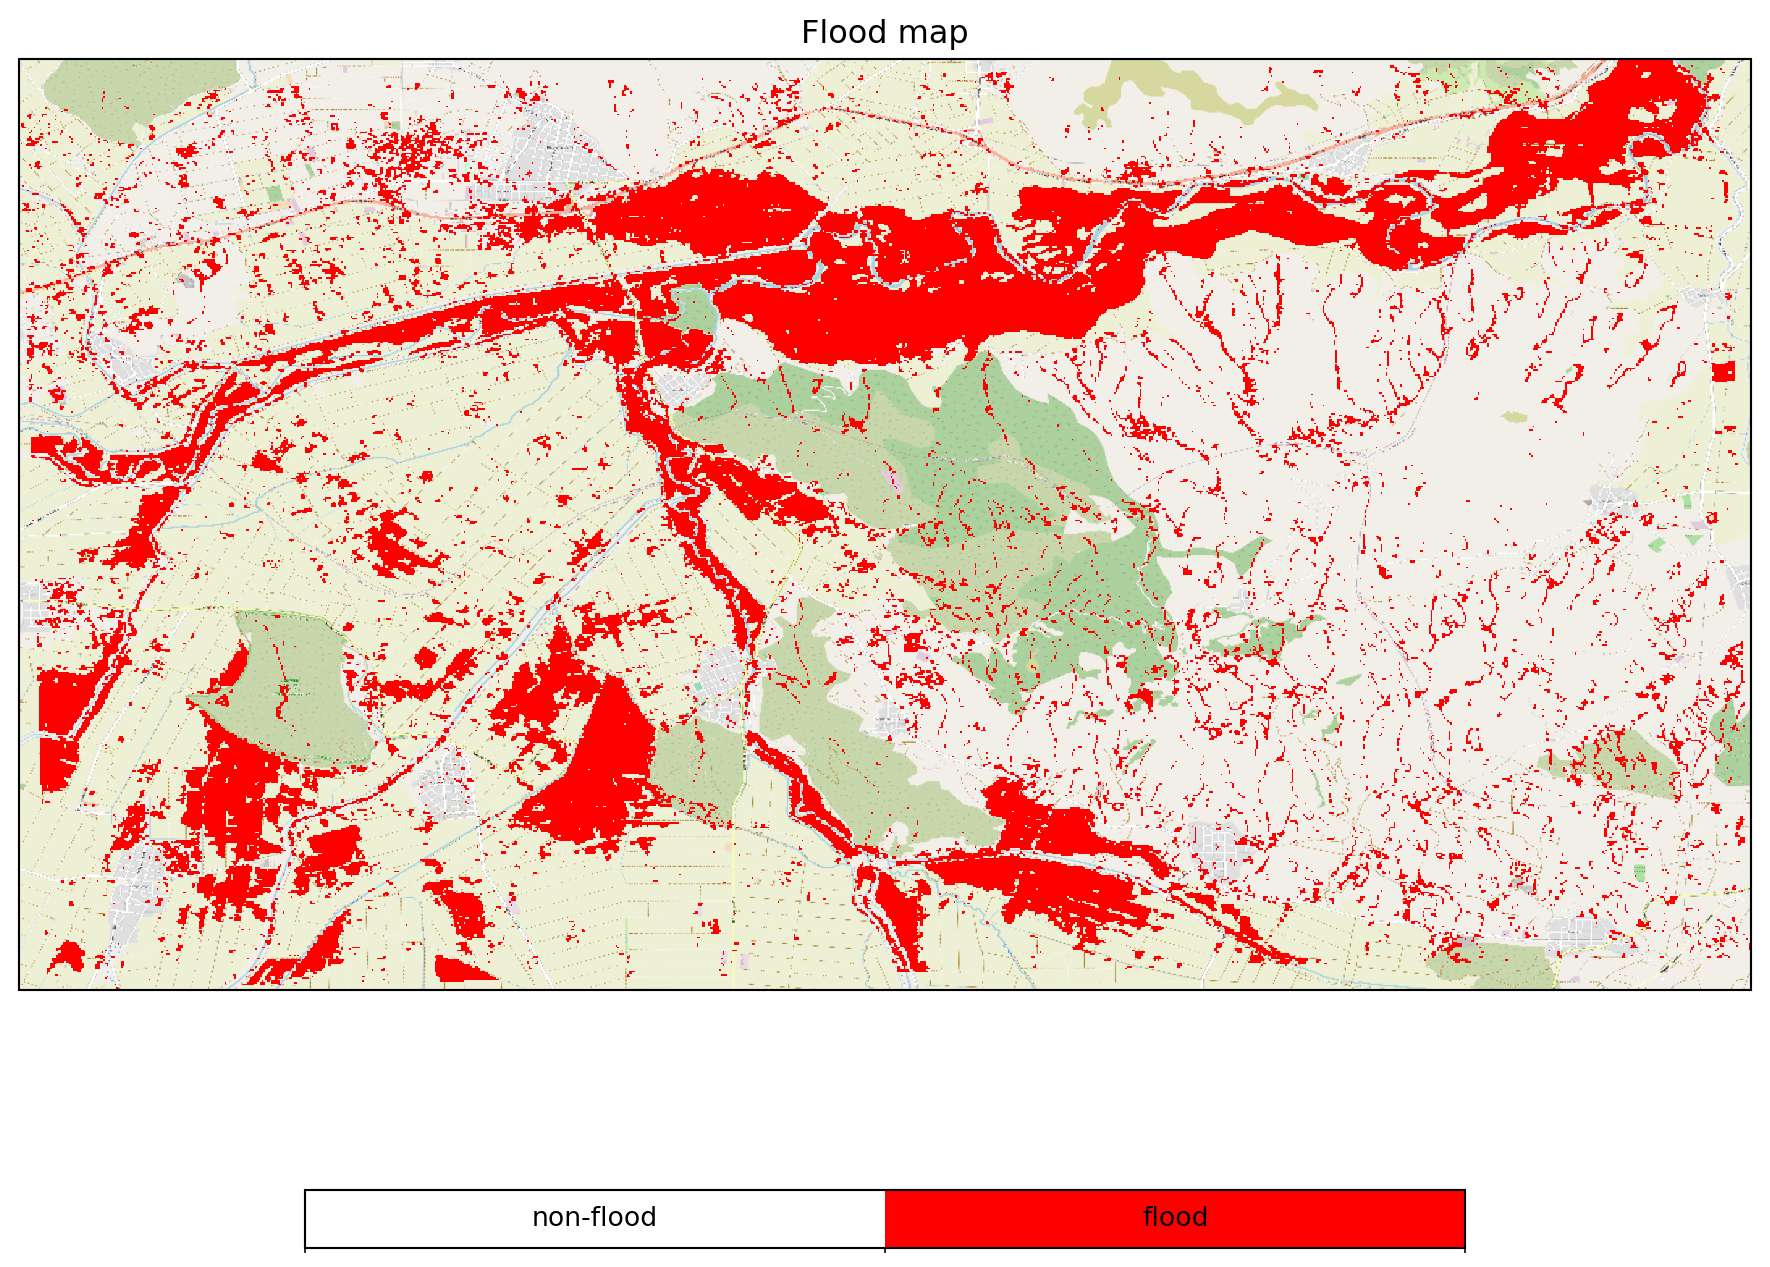

In [39]:
#| fig-cap: openEO floodmap - masking high uncertainty classifications + extreme outliers + conflicting distributions + exceeding incidence angles
#| echo: false
view_flood_map(xr.open_dataset("data/thessaly_floodmap_plia_distr_out_den.nc").dec)